<a href="https://colab.research.google.com/github/KevinGomez26/Pain_classification/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import glob
! pip install mne
import mne

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

!pip install transformers
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer
import torch

from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

!pip install import-ipynb
import import_ipynb
from drive.MyDrive.EMBC_2024.EEGNet_model import EEGNet_feature_extractor
from drive.MyDrive.EMBC_2024.ResNet50_model import ResNet_embedding

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data

In [ ]:
survey_path = '/content/drive/MyDrive/EMBC_2024/Data/DEMOGR~1.xlsx'
survey = pd.read_excel(survey_path, sheet_name='Demographics')

eeg_path = '/content/drive/MyDrive/EMBC_2024/Data/**.gdf'
eeg_files = glob.glob(eeg_path)
raw_eeg = []
for eeg_file in eeg_files: raw_eeg.append(mne.io.read_raw_gdf(eeg_file, preload=True))

Extracting EDF parameters from /content/drive/MyDrive/EMBC_2024/Data/ID0.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, P8, Fz, Cz, Pz, M1, M2, AFz, CPz, POz
Creating raw.info structure...
Reading 0 ... 149951  =      0.000 ...   599.804 secs...
Extracting EDF parameters from /content/drive/MyDrive/EMBC_2024/Data/ID1.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, P8, Fz, Cz, Pz, M1, M2, AFz, CPz, POz
Creating raw.info structure...
Reading 0 ... 151455  =      0.000 ...   605.820 secs...
Extracting EDF parameters from /content/drive/MyDrive/EMBC_2024/Data/ID2.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels

#Preprocessing data

Pain scale

*   Low:    0 to 2
*   Medium: 3 to 5
*   High:   6 to 10

In [ ]:
survey = survey.drop([36, 37, 38, 39], axis=0)
survey.fillna('Unknown', inplace=True)
survey['Gender'].replace(['F', 'M'], ['Femenine', 'Masculine'], inplace=True)

survey['Pain Scale'] = pd.cut(survey['Pain Score (Actual Pain of Brief Pain Inventory)'],
                                   bins=[-1, 3, 6, 11], labels=['Low', 'Moderate', 'Severe']).astype('object')

survey = survey.drop(['Have you suffered any head traumatism? ',
                      'Do you suffer from any neurological disorder? (eg. epilepsy, Alzheimer, tinnitus)',
                      'Pain Score (Actual Pain of Brief Pain Inventory)'], axis=1)

#Exp 1: Survey (RF)

In [ ]:
survey_numeric = survey.copy()
for column_name in survey.columns:
  if survey[column_name].dtypes == object:
    survey_numeric[column_name] = pd.Categorical(survey[column_name], categories=survey[column_name].unique()).codes

In [ ]:
y = survey_numeric['Pain Scale']
x = survey_numeric.drop(['ID', 'Pain Scale'], axis=1)

RF_model = RandomForestClassifier()
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=False)
cross_val_scores = cross_val_score(RF_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.3286  ±  0.1245


#Exp 2: Survey (BERT ~ SVM)

In [ ]:
survey_sentence = []
for i in range(survey.shape[0]):
  survey_sentence.append('The patient, with ID' + str(survey.iloc[i]['ID']) + ', their age is '+str(int(survey.iloc[i]['Age']))+' years, and they identify as '+str(survey.iloc[i]['Gender'])+'. The etiology of their neuropathic pain (NP) is associated with '+str(survey.iloc[i]['Etiology of NP*'])+'. The patient has been experiencing NP for '+str(survey.iloc[i]['Time with NP'])+'. They are currently undergoing '+str(survey.iloc[i]['Medical treatment for NP'])+' treatment and have been using medication since '+str(survey.iloc[i]['Since when have you use the previous medication?'])+'. Regarding medical procedures, the patient has '+str(survey.iloc[i]['Have you had any medical procedures to control the pain?'])+'. Additionally, they '+str(survey.iloc[i]['Do you go regularly to phsychological or emotional counseling sessions for your pain?'])+' regularly attend psychological or emotional counseling sessions for their pain management.')

In [ ]:
survey_text = []
for patient_id in range(survey.shape[0]):
  text = ''
  for column in survey.columns: text = text + str(survey.iloc[patient_id][column]) + '\n'
  survey_text.append(text)
print(survey_text[0])

0
25.0
Femenine
Central Nervous System Disorder (CRPS or Lyme)
More than 2 years
Pregabalin, amitriptyline
More than a year ago
Nerve blocks and infusions*
Yes
High



In [ ]:
BERT_model = AutoModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

In [ ]:
survey_embedding = []
for text in survey_text:
  inputs = tokenizer(text, padding=True, truncation=True, max_length = 512, return_tensors="pt")
  with torch.no_grad():
    outputs = BERT_model(**inputs)
  survey_embedding.append(outputs.last_hidden_state[:, 0, :][0].numpy())
survey_embedding = np.array(survey_embedding).reshape(survey.shape[0], outputs.last_hidden_state[:, 0, :][0].shape[0])

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
survey_tsne = tsne.fit_transform(survey_embedding)
survey_tsne = pd.DataFrame(survey_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
survey_tsne['Text'] = survey_text

fig = px.scatter_3d(survey_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="Survey embedding ~ BERT",
                    hover_data=['Text'],
                    color=survey['Pain Scale'],
                    labels={'color': 'Pain Scale'})
fig.show()

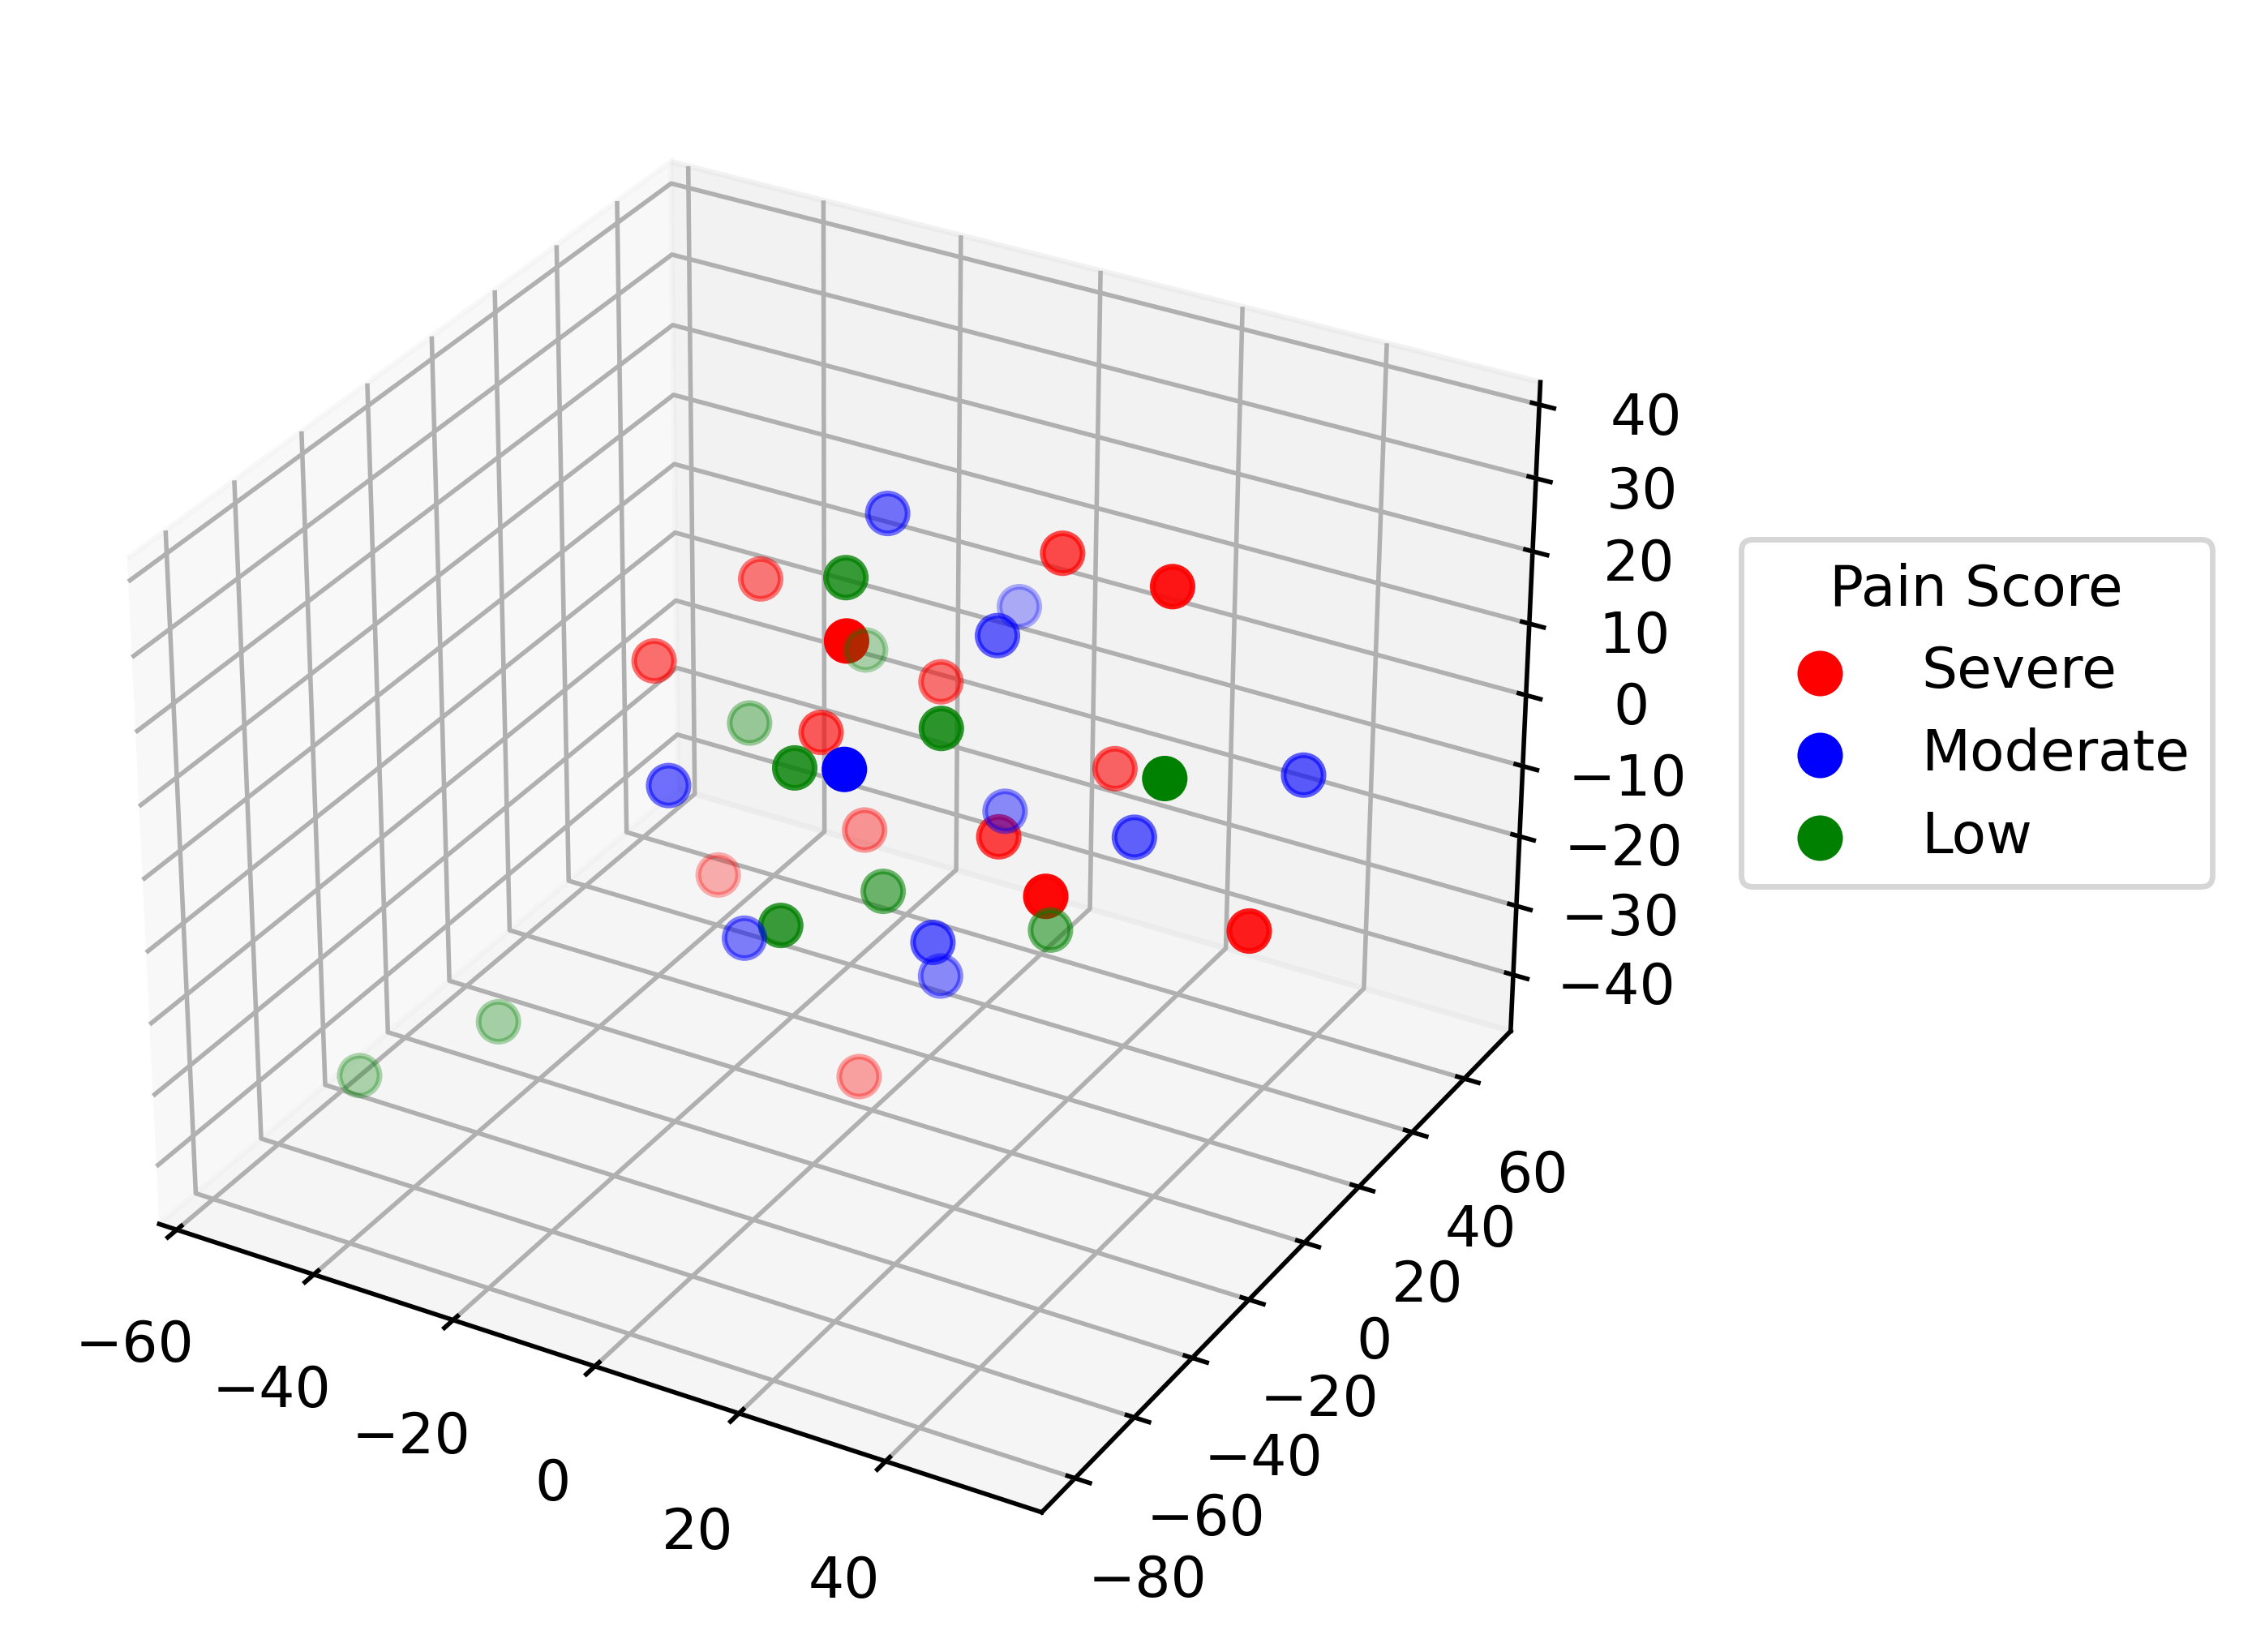

In [ ]:
fig = plt.figure(figsize=(5, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']
for i, pain in enumerate(survey['Pain Scale'].unique()):

  ax.scatter(survey_tsne['Dimension 1'][survey['Pain Scale']==pain],
            survey_tsne['Dimension 2'][survey['Pain Scale']==pain],
            survey_tsne['Dimension 3'][survey['Pain Scale']==pain],
            c=colors[i], marker='o', label=pain, s=50)

plt.legend(title='Pain Score', loc='upper right', bbox_to_anchor=(1.4, 0.7))
#ax.set_title('Survey embedding ~ BERT')
plt.show()

In [ ]:
y = survey['Pain Scale']
x = survey_embedding

svm_model = SVC()
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.5286  ±  0.14


#Exp 3: EEG (EEGNet ~ SVM)

In [ ]:
mode_type = 'complete'
window_size=20

eeg_complete_features = np.array([])
eeg_complete_id = []
for i, raw in enumerate(raw_eeg):

  eeg_features = EEGNet_feature_extractor(raw, window_size, mode_type, survey_embedding)

  patient_id = int(eeg_files[i].split('/')[-1].split('.')[0].split('D')[-1])
  eeg_complete_id = np.concatenate([eeg_complete_id, patient_id * np.ones((eeg_features.shape[0],))])

  if len(eeg_complete_features)==0: eeg_complete_features = eeg_features
  else: eeg_complete_features = np.vstack((eeg_complete_features, eeg_features))

TypeError: EEGNet_feature_extractor() takes 3 positional arguments but 4 were given

In [ ]:
eeg_complete_features.shape

(1044, 2496)

In [ ]:
eeg_complete_labels =[]
for eeg_id in eeg_complete_id:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): eeg_complete_labels.append(pain_scale)

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 29 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = eeg_complete_features[fold*data_partition:(fold+1)* data_partition]
  labels = eeg_complete_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.3635  ±  0.0613


In [ ]:
y = eeg_complete_labels
x = eeg_complete_features

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.3981  ±  0.0873


#Exp 4: EEG (Open)(EEGNet ~ SVM)

In [ ]:
mode_type = 'open_eyes'
window_size=20

eeg_open_features = np.array([])
eeg_open_id = []
for i, raw in enumerate(raw_eeg):

  eeg_features = EEGNet_feature_extractor(raw, window_size, mode_type)

  patient_id = int(eeg_files[i].split('/')[-1].split('.')[0].split('D')[-1])
  eeg_open_id = np.concatenate([eeg_open_id, patient_id * np.ones((eeg_features.shape[0],))])

  if len(eeg_open_features)==0: eeg_open_features = eeg_features
  else: eeg_open_features = np.vstack((eeg_open_features, eeg_features))

In [ ]:
eeg_open_features.shape

(504, 2496)

In [ ]:
eeg_open_labels =[]
for eeg_id in eeg_open_id:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): eeg_open_labels.append(pain_scale)

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 14 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = eeg_open_features[fold*data_partition:(fold+1)* data_partition]
  labels = eeg_open_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.3959  ±  0.0825


In [ ]:
y = eeg_open_labels
x = eeg_open_features

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.3946  ±  0.1283


#Exp 5: EEG (Closed)(EEGNet ~ SVM)

In [ ]:
mode_type = 'closed_eyes'
window_size=20

eeg_closed_features = np.array([])
eeg_closed_id = []
for i, raw in enumerate(raw_eeg):

  eeg_features = EEGNet_feature_extractor(raw, window_size, mode_type)

  patient_id = int(eeg_files[i].split('/')[-1].split('.')[0].split('D')[-1])
  eeg_closed_id = np.concatenate([eeg_closed_id, patient_id * np.ones((eeg_features.shape[0],))])

  if len(eeg_closed_features)==0: eeg_closed_features = eeg_features
  else: eeg_closed_features = np.vstack((eeg_closed_features, eeg_features))

In [ ]:
eeg_closed_labels =[]
for eeg_id in eeg_closed_id:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): eeg_closed_labels.append(pain_scale)

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 14 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = eeg_closed_features[fold*data_partition:(fold+1)* data_partition]
  labels = eeg_closed_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.3633  ±  0.0523


In [ ]:
y = eeg_closed_labels
x = eeg_closed_features

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.3624  ±  0.0645


#Exp 6: EEG (ResNet ~ SVM)

In [ ]:
topoplot_complete_path = '/content/drive/MyDrive/EMBC_2024/topoplot_images_20s/**.png'
topoplot_complete_embeddings, topoplot_complete_files = ResNet_embedding(survey_embedding, topoplot_complete_path)

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
topoplot_complete_embeddings.shape

(1080, 768)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
topoplot_complete_tsne = tsne.fit_transform(topoplot_complete_embeddings)
topoplot_complete_tsne = pd.DataFrame(topoplot_complete_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

label = []
for topoplot_file in topoplot_complete_files:
  label.append(topoplot_file.split('/')[-1].split('_')[0].split('D')[-1])
topoplot_complete_tsne['ID'] = label

fig = px.scatter_3d(topoplot_complete_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots embedding ~ ResNet",
                    color=topoplot_complete_tsne['ID'],
                    labels={'color': 'Patient'})
fig.show()

In [ ]:
topoplot_complete_labels =[]
for eeg_id in topoplot_complete_tsne['ID']:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): topoplot_complete_labels.append(pain_scale)

In [ ]:
fig = px.scatter_3d(topoplot_complete_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots embedding ~ ResNet",
                    color=topoplot_complete_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

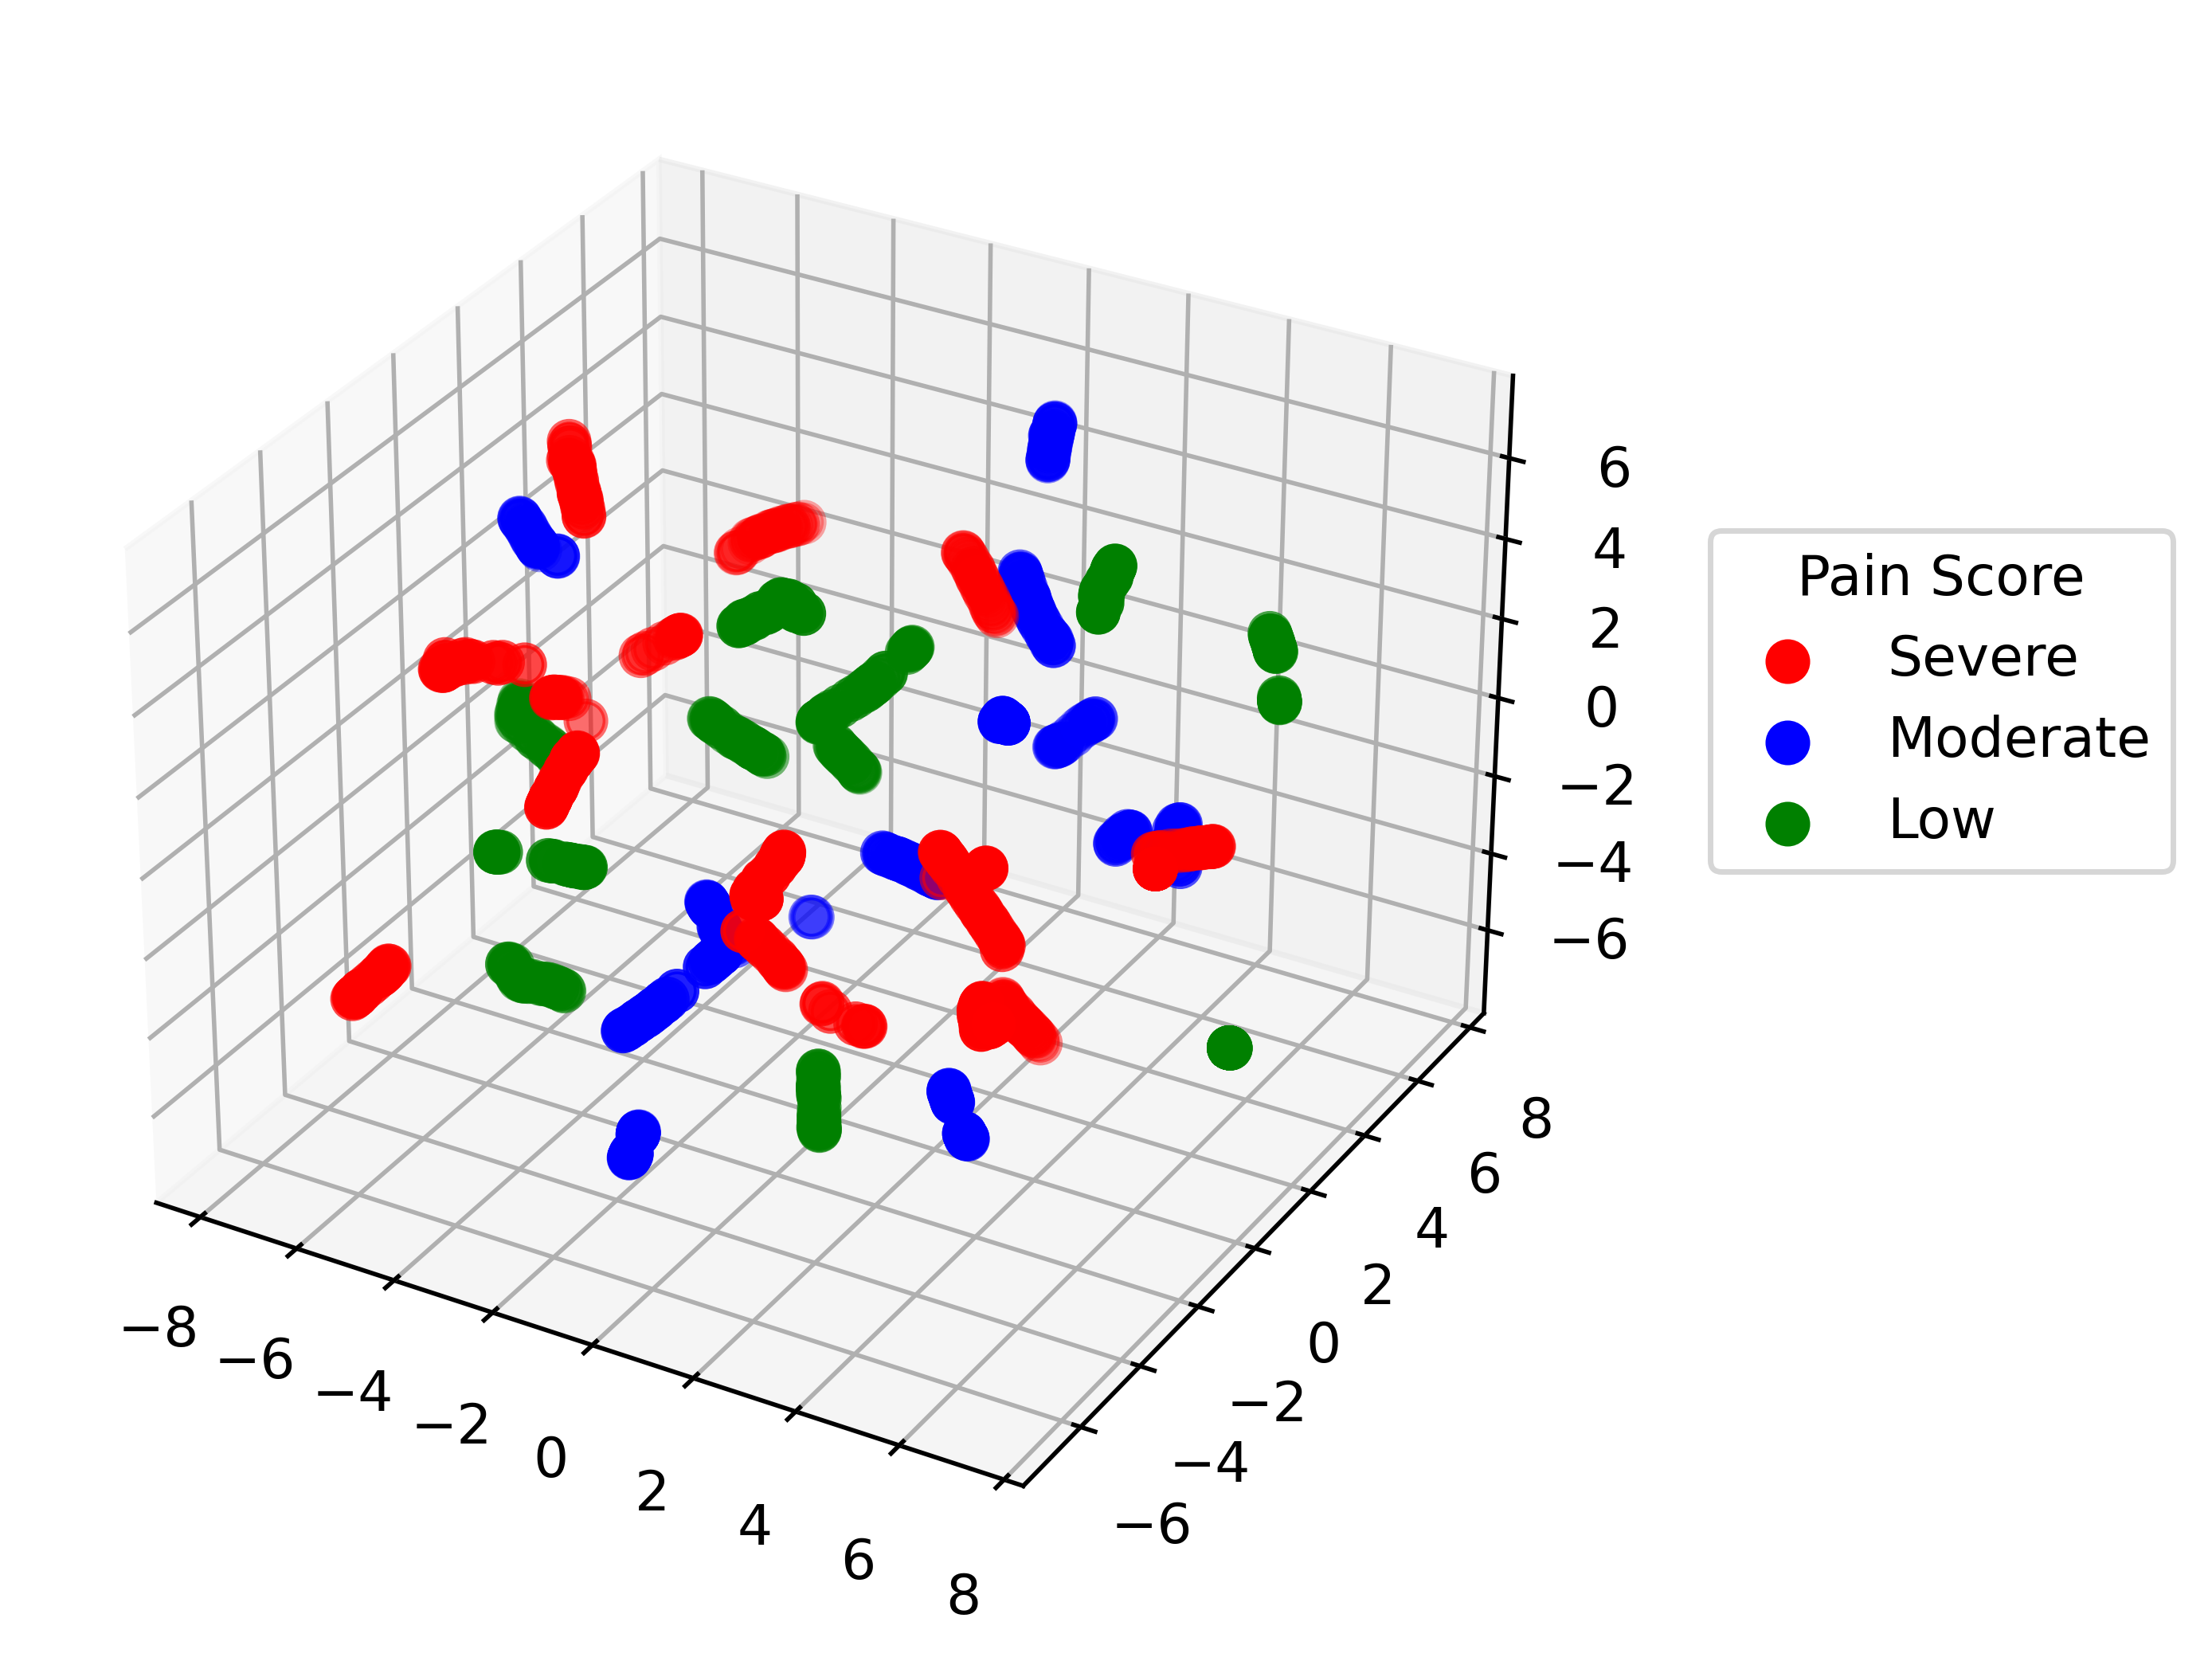

In [ ]:
fig = plt.figure(figsize=(5, 10), dpi=500)
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']
for i, pain in enumerate(survey['Pain Scale'].unique()):

  ax.scatter(topoplot_complete_tsne['Dimension 1'][np.where(np.array(topoplot_complete_labels) == pain)[0]],
            topoplot_complete_tsne['Dimension 2'][np.where(np.array(topoplot_complete_labels) == pain)[0]],
            topoplot_complete_tsne['Dimension 3'][np.where(np.array(topoplot_complete_labels) == pain)[0]],
            c=colors[i], marker='o', label=pain, s=50)

plt.legend(title='Pain Score', loc='upper right', bbox_to_anchor=(1.4, 0.7))
#ax.set_title('Topo-plots embedding ~ ResNet')
plt.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 30 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = topoplot_complete_embeddings[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_complete_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.4114  ±  0.0821


In [ ]:
y = topoplot_complete_labels
x = topoplot_complete_embeddings

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.5511  ±  0.1463


#Exp 7: EEG (Open)(ResNet ~ SVM)

In [ ]:
topoplot_open_path = '/content/drive/MyDrive/EMBC_2024/topoplot_images_open_eyes_20s/**.png'
topoplot_open_embeddings, topoplot_open_files  = ResNet_embedding(survey_embedding, topoplot_open_path)

In [ ]:
topoplot_open_embeddings.shape

(540, 768)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
topoplot_open_tsne = tsne.fit_transform(topoplot_open_embeddings)
topoplot_open_tsne = pd.DataFrame(topoplot_open_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

label = []
for topoplot_file in topoplot_open_files:
  label.append(topoplot_file.split('/')[-1].split('_')[0].split('D')[-1])
topoplot_open_tsne['ID'] = label

fig = px.scatter_3d(topoplot_open_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots (Open) embedding ~ ResNet",
                    color=topoplot_open_tsne['ID'],
                    labels={'color': 'Patient'})
fig.show()

In [ ]:
topoplot_open_labels =[]
for eeg_id in topoplot_open_tsne['ID']:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): topoplot_open_labels.append(pain_scale)

In [ ]:
fig = px.scatter_3d(topoplot_open_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots (Open) embedding ~ ResNet",
                    color=topoplot_open_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 15 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = topoplot_open_embeddings[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_open_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.3733  ±  0.1265


In [ ]:
y = topoplot_open_labels
x = topoplot_open_embeddings

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.3588  ±  0.2115


#Exp 8: EEG (Closed)(ResNet ~ SVM)

In [ ]:
topoplot_closed_path = '/content/drive/MyDrive/EMBC_2024/topoplot_images_closed_eyes_20s/**.png'
topoplot_closed_embeddings, topoplot_closed_files = ResNet_embedding(survey_embedding, topoplot_closed_path)

In [ ]:
topoplot_closed_embeddings.shape

(540, 768)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
topoplot_closed_tsne = tsne.fit_transform(topoplot_closed_embeddings)
topoplot_closed_tsne = pd.DataFrame(topoplot_closed_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

label = []
for topoplot_file in topoplot_closed_files:
  label.append(topoplot_file.split('/')[-1].split('_')[0].split('D')[-1])
topoplot_closed_tsne['ID'] = label

fig = px.scatter_3d(topoplot_closed_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots (Closed) embedding ~ ResNet",
                    color=topoplot_closed_tsne['ID'],
                    labels={'color': 'Patient'})
fig.show()

In [ ]:
topoplot_closed_labels =[]
for eeg_id in topoplot_closed_tsne['ID']:
  for pain_scale in survey['Pain Scale'].unique():
    if int(eeg_id) in list(survey['ID'][survey['Pain Scale']==pain_scale]): topoplot_closed_labels.append(pain_scale)

In [ ]:
fig = px.scatter_3d(topoplot_closed_tsne, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="TopoPlots (Closed) embedding ~ ResNet",
                    color=topoplot_closed_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 15 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = topoplot_closed_embeddings[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_closed_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.4438  ±  0.2202


In [ ]:
y = topoplot_closed_labels
x = topoplot_closed_embeddings

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.5592  ±  0.2172


#Exp 9: Survey + EEG (BERT ~ ResNet ~ SVM)

In [ ]:
survey_eeg_complete_embedding = []
for i, topo_emb in enumerate(topoplot_complete_embeddings):
  eeg_id = int(topoplot_complete_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eeg_complete_embedding.append(emb)
survey_eeg_complete_embedding = np.array(survey_eeg_complete_embedding)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(survey_eeg_complete_embedding)
tsne_sec = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

fig = px.scatter_3d(tsne_sec, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="Survey (+) EEG (Complete) embedding ~ BERT + ResNet",
                    color=topoplot_complete_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 30 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = survey_eeg_complete_embedding[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_complete_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.8267  ±  0.0463


In [ ]:
y = topoplot_complete_labels
x = survey_eeg_complete_embedding

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.8231  ±  0.1864


#Exp 10: Survey + EEG (Open)(BERT ~ ResNet ~ SVM)

In [ ]:
survey_eeg_open_embedding = []
for i, topo_emb in enumerate(topoplot_open_embeddings):
  eeg_id = int(topoplot_open_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eeg_open_embedding.append(emb)
survey_eeg_open_embedding = np.array(survey_eeg_open_embedding)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(survey_eeg_open_embedding)
tsne_sec = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

fig = px.scatter_3d(tsne_sec, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="Survey (+) EEG (Open) embedding ~ BERT + ResNet",
                    color=topoplot_open_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 15 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = survey_eeg_open_embedding[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_open_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.6286  ±  0.1873


In [ ]:
y = topoplot_open_labels
x = survey_eeg_open_embedding

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.7743  ±  0.2401


#Exp 11: Survey + EEG (Closed)(BERT ~ ResNet ~ SVM)

In [ ]:
survey_eeg_closed_embedding = []
for i, topo_emb in enumerate(topoplot_closed_embeddings):
  eeg_id = int(topoplot_closed_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eeg_closed_embedding.append(emb)
survey_eeg_closed_embedding = np.array(survey_eeg_closed_embedding)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(survey_eeg_closed_embedding)
tsne_sec = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

fig = px.scatter_3d(tsne_sec, x='Dimension 1', y='Dimension 2', z='Dimension 3',
                    title="Survey (+) EEG (Closed) embedding ~ BERT + ResNet",
                    color=topoplot_closed_labels,
                    labels={'color': 'Pain Scale'})
fig.show()

In [ ]:
# 36 (kfol = 5) ~ 7 -> 210
num_folds = 5
data_partition = 15 * int(survey.shape[0] / num_folds)
kfolds=[]
kfold_labels = []
for fold in range(num_folds):
  kfold = survey_eeg_closed_embedding[fold*data_partition:(fold+1)* data_partition]
  labels = topoplot_closed_labels[fold*data_partition:(fold+1)* data_partition]
  kfolds.append(kfold)
  kfold_labels.append(labels)

In [ ]:
svm_model = SVC()
accuracy = []
for fold_out in range(num_folds):

  x_train = np.delete(kfolds, fold_out, axis=0)
  x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2]))

  y_train = np.delete(kfold_labels, fold_out, axis=0)
  y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1]))

  x_test = kfolds[fold_out]
  y_test = kfold_labels[fold_out]

  svm_model.fit(x_train, y_train)
  y_pred = svm_model.predict(x_test)
  accuracy.append(accuracy_score(y_test, y_pred))

print('Cross Validation Score: ', round(np.mean(accuracy), 4), ' ± ', round(np.std(accuracy), 4))

Cross Validation Score:  0.6648  ±  0.2281


In [ ]:
y = topoplot_closed_labels
x = survey_eeg_closed_embedding

svm_model = SVC()
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=False)
cross_val_scores = cross_val_score(svm_model, x, y, cv=kfold)
print('Cross Validation Score: ', round(cross_val_scores.mean(), 4), ' ± ', round(cross_val_scores.std(), 4))

Cross Validation Score:  0.779  ±  0.1927


#Exp 12: Survey + EEG (BERT ~ EEGNet ~ SVM)

In [ ]:
survey_eegnet_complete_embedding = []
for i, topo_emb in enumerate(eeg_complete_features):
  eeg_id = int(topoplot_closed_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eegnet_complete_embedding.append(emb)
survey_eegnet_complete_embedding = np.array(survey_eegnet_complete_embedding)

IndexError: single positional indexer is out-of-bounds

#Exp 13: Survey + EEG (Open)(BERT ~ EEGNet ~ SVM)

In [ ]:
survey_eeg_closed_embedding = []
for i, topo_emb in enumerate(topoplot_closed_embeddings):
  eeg_id = int(topoplot_closed_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eeg_closed_embedding.append(emb)
survey_eeg_closed_embedding = np.array(survey_eeg_closed_embedding)

#Exp 14: Survey + EEG (Closed)(BERT ~ EEGNet ~ SVM)

In [ ]:
survey_eeg_closed_embedding = []
for i, topo_emb in enumerate(topoplot_closed_embeddings):
  eeg_id = int(topoplot_closed_tsne.iloc[i]['ID'])
  pat_id = survey[survey['ID']==eeg_id].index[0]
  emb = np.hstack((topo_emb, survey_embedding[pat_id]))
  survey_eeg_closed_embedding.append(emb)
survey_eeg_closed_embedding = np.array(survey_eeg_closed_embedding)